In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
from datetime import datetime

import json
import pickle

# Our generated code
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
%load_ext autoreload
%autoreload 2
    
from libs import exploring as explore
from libs import visualising as visualize
from libs import cleansing as cleanse

PLOT = True

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [47]:
# Import data
open_food_facts_csv_file = "./data/en.openfoodfacts.org.products.csv"

# Load list of columns (external file) that are loaded into pyspark
data = []
with open("./data/cleanse/columns_to_import.txt", "r") as json_data:
    columns_to_import = json.load(json_data)
    columns_to_import


food_facts_pd = pd.read_csv(open_food_facts_csv_file,
                            delimiter="\t",
                            usecols=columns_to_import.keys(),
                            dtype=columns_to_import)

In [48]:
data_summary_string = "The dataset now comprises {} entries, of which we have {} features."
data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1])

'The dataset now comprises 356027 entries, of which we have 22 features.'

# Explore the data

In [49]:
food_facts_pd.head(10)

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,origins_tags,...,labels_en,purchase_places,stores,countries_en,ingredients_text,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
0,0000000003087,1474103866,2016-09-17T09:17:46Z,Farine de blé noir,1kg,NaN,Ferme t'y R'nao,NaN,NaN,NaN,...,NaN,NaN,NaN,France,NaN,NaN,NaN,NaN,NaN,NaN
1,0000000004530,1489069957,2017-03-09T14:32:37Z,Banana Chips Sweetened (Whole),NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,United States,"Bananas, vegetable oil (coconut oil, corn oil ...",NaN,2243.0,NaN,14,14
2,0000000004559,1489069957,2017-03-09T14:32:37Z,Peanuts,NaN,NaN,Torn & Glasser,NaN,NaN,NaN,...,NaN,NaN,NaN,United States,"Peanuts, wheat flour, sugar, rice flour, tapio...",NaN,1941.0,NaN,0,0
3,0000000016087,1489055731,2017-03-09T10:35:31Z,Organic Salted Nut Mix,NaN,NaN,Grizzlies,NaN,NaN,NaN,...,NaN,NaN,NaN,United States,"Organic hazelnuts, organic cashews, organic wa...",NaN,2540.0,NaN,12,12
4,0000000016094,1489055653,2017-03-09T10:34:13Z,Organic Polenta,NaN,NaN,Bob's Red Mill,NaN,NaN,NaN,...,NaN,NaN,NaN,United States,Organic polenta,NaN,1552.0,NaN,NaN,NaN
5,0000000016100,1489055651,2017-03-09T10:34:11Z,Breadshop Honey Gone Nuts Granola,NaN,NaN,Unfi,NaN,NaN,NaN,...,NaN,NaN,NaN,United States,"Rolled oats, grape concentrate, expeller press...",NaN,1933.0,NaN,NaN,NaN
6,0000000016117,1489055730,2017-03-09T10:35:30Z,Organic Long Grain White Rice,NaN,NaN,Lundberg,NaN,NaN,NaN,...,NaN,NaN,NaN,United States,Organic long grain white rice,NaN,1490.0,NaN,NaN,NaN
7,0000000016124,1489055711,2017-03-09T10:35:11Z,Organic Muesli,NaN,NaN,Daddy's Muesli,NaN,NaN,NaN,...,NaN,NaN,NaN,United States,"Org oats, org hemp granola (org oats, evaporat...",NaN,1833.0,NaN,7,7
8,0000000016193,1489055651,2017-03-09T10:34:11Z,Organic Dark Chocolate Minis,NaN,NaN,Equal Exchange,NaN,NaN,NaN,...,NaN,NaN,NaN,United States,"Organic chocolate liquor, organic raw cane sug...",NaN,2406.0,NaN,NaN,NaN
9,0000000016513,1489055654,2017-03-09T10:34:14Z,Organic Sunflower Oil,NaN,NaN,Napa Valley Naturals,NaN,NaN,NaN,...,NaN,NaN,NaN,United States,"Organic expeller pressed, refined high oleic s...",NaN,3586.0,NaN,NaN,NaN


## Display number of NaN entries per column

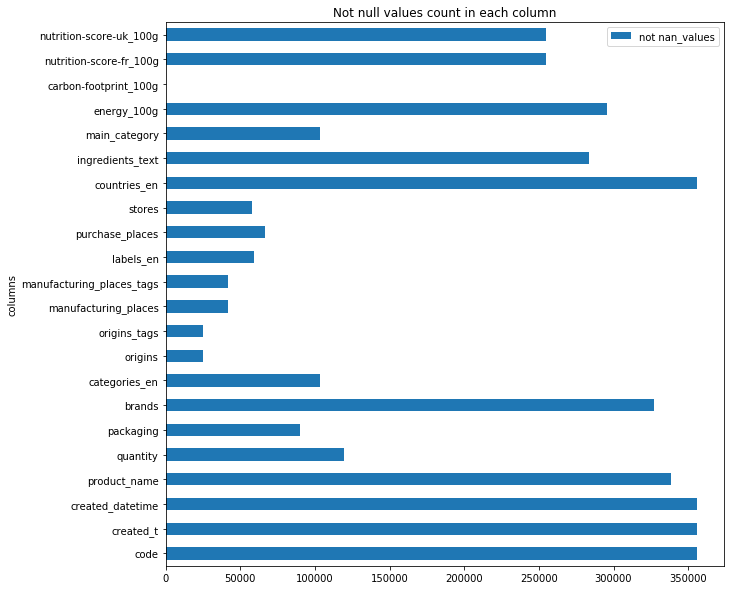

In [50]:
null_entries = pd.DataFrame({'columns' : food_facts_pd.columns,
                             'not nan_values' : [food_facts_pd[c].count() for c in food_facts_pd]
                            })

# Plot NaNs counts
if PLOT:
    null_entries.set_index('columns').plot(kind='barh', figsize=(10, 10))
    plt.title("Not null values count in each column")
    plt.show()

We see that there are many NaN entries in this data set. For our analysis, we can only use entries that have at least a product name, country tag, manufacturing and purchase place, and a created date tag. Unfortunately, we have to drop all columns, that lack those data.

In [51]:
no_rows_inital = food_facts_pd.shape[0]

# Drop entries with missing entries in of our main-features
essential_columns = ['created_t', 'product_name', 'countries_en', 'categories_en', 'manufacturing_places', 'purchase_places']
food_facts_pd = food_facts_pd.dropna(subset=essential_columns, )

no_rows_reduced_nan = food_facts_pd.shape[0]

# Also drop duplicated values (indentify based on index (barcode))
food_facts_pd = food_facts_pd.drop_duplicates()

no_rows_reduced_duplicates = food_facts_pd.shape[0]

print("{} entries were dropped, of which {} were duplicates."\
      .format(no_rows_inital-no_rows_reduced_duplicates, no_rows_reduced_nan-no_rows_reduced_duplicates))
print(data_summary_string.format(food_facts_pd.shape[0], food_facts_pd.shape[1]))

320916 entries were dropped, of which 0 were duplicates.
The dataset now comprises 35111 entries, of which we have 22 features.


Puhh, that was though. From now on, we are going to rescue the data and enrich wherever we can.

In [52]:
# Replace NaNs with emptry string
food_facts_pd = food_facts_pd.fillna("")

In [12]:
# Next lets look at the data types:

In [53]:
food_facts_pd.dtypes

code                         object
created_t                    object
created_datetime             object
product_name                 object
quantity                     object
packaging                    object
brands                       object
categories_en                object
origins                      object
origins_tags                 object
manufacturing_places         object
manufacturing_places_tags    object
labels_en                    object
purchase_places              object
stores                       object
countries_en                 object
ingredients_text             object
main_category                object
energy_100g                  object
carbon-footprint_100g        object
nutrition-score-fr_100g      object
nutrition-score-uk_100g      object
dtype: object

Another thing that we are not really keen of are the language indicators, so we are going to remove those abbreviations.

In [57]:
def remove_language_indicator(row_str):
    tags = [tag if len(tag.split(':'))==1 else tag.split(':')[1] for tag in row_str.split(',')]
    return ",".join(tags)

In [58]:
food_facts_pd.categories_en = food_facts_pd.categories_en.apply(remove_language_indicator)
food_facts_pd.main_category = food_facts_pd.main_category.apply(remove_language_indicator)
food_facts_pd.countries_en = food_facts_pd.countries_en.apply(remove_language_indicator)
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(remove_language_indicator)

The next issue we are going to tackel are redudant columns. Especially here, these are similarly named columns ending with "_en", "_tags". We are handling this, by only importing columns that end with "_en" if we have the choice.

In [59]:
food_facts_pd

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,origins_tags,...,labels_en,purchase_places,stores,countries_en,ingredients_text,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
177,0000000394710,1484497370,2017-01-15T16:22:50Z,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",Québec,quebec,...,,Brossard Québec,Costco,Canada,"Ingrédients: Pâte (farine, eau, beurre, sucre,...",sugary-snacks,1520,,,
179,0000001071894,1409411252,2014-08-30T15:07:32Z,Flute,,"Paper,plastic film",Waitrose,"Plant-based foods and beverages,Plant-based fo...",France,france,...,,"Brent,UK",Waitrose,United Kingdom,Wheat,plant-based-foods-and-beverages,,,,
182,0000001938067,1484501528,2017-01-15T17:32:08Z,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",Québec,quebec,...,,Brossard Québec,Costco,Canada,"Ingrédients : Pâte (farine, margarines d'huile...",sugary-snacks,1090,,9,9
183,0000004302544,1488464896,2017-03-02T14:28:16Z,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,Boulange,Québec,quebec,...,,"Brossard,Québec",Costco,Canada,"Ingrédients : Farine, eau, sel, levure, orge m...",boulange,1160,,1,1
185,0000007020254,1420150193,2015-01-01T22:09:53Z,Root Beer,33 cl e,"Canette,Métal",A&W,"Beverages,Carbonated drinks,Sodas,Sugared beve...",,,...,"Kosher,Contient-des-ogm",France,,France,"Eau gazéifiée, sirop de maïs à haute teneur en...",beverages,215,,18,3
186,0000007730009,1462806432,2016-05-09T15:07:12Z,Biscuits sablés fourrage au cacao,1 kg,"Carton,boîte",St Michel,"Sugary snacks,Biscuits and cakes,Biscuits,Sablés",,,...,Green Dot,France,,France,"Sucre, farine de _Blé_, graisse et huiles végé...",sugary-snacks,,,,
187,0000008237798,1491943307,2017-04-11T20:41:47Z,Quiche Lorraine,1 400 kg,Frai,Kirkland Signature,"Meals,Pizzas pies and quiches,Quiches,Quiches ...",Québec,quebec,...,,"Brossard,Québec",Costco,Canada,INGRÉDIENTS : GARNITURE (SUBSTANCES LAITIÈRES....,meals,478,,2,2
188,0000008240095,1484342673,2017-01-13T21:24:33Z,Pâté au poulet,1250 kg,Frais,Kirkland Signature,"Meats,Poultries,Chickens,Cooked chicken",Québec,quebec,...,,Brossard Québec,Costco,Canada,,meats,751,,,
191,0000010090206,1370977431,2013-06-11T19:03:51Z,Thé de Noël aromatisé orange-cannelle,75 g,aluminium,Alice Délice,"Plant-based foods and beverages,Beverages,Plan...",,,...,,"Lyon,France",Alice Délice,France,"Thé noir de Chine, zestes d'oranges 7,5 %, arô...",beverages,,,,
197,0000012345878,1461364956,2016-04-22T22:42:36Z,เล็บมือนาง (ตีนไก่ ),500 g,plastic,Thai import,Chicken-feet,,,...,Incorrect data on label,"Liverpool,United Kingdom",,United Kingdom,ตีนไก่,chicken-feet,,,,


## Unitize tags
Many parts of the data are categorizations based on tags. However, those tags are in a variety of languages and string formattings, so in order to use them we attempt to group tags that hint to the same property and map them to a common indicator. 

Every column of the data set requires special treatment, as follows:

### Countries tags

In [60]:
food_facts_pd = food_facts_pd.dropna(subset=['product_name', 'countries_en', 'stores'])

In [61]:
food_facts_pd

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,origins,origins_tags,...,labels_en,purchase_places,stores,countries_en,ingredients_text,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g
177,0000000394710,1484497370,2017-01-15T16:22:50Z,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",Québec,quebec,...,,Brossard Québec,Costco,Canada,"Ingrédients: Pâte (farine, eau, beurre, sucre,...",sugary-snacks,1520,,,
179,0000001071894,1409411252,2014-08-30T15:07:32Z,Flute,,"Paper,plastic film",Waitrose,"Plant-based foods and beverages,Plant-based fo...",France,france,...,,"Brent,UK",Waitrose,United Kingdom,Wheat,plant-based-foods-and-beverages,,,,
182,0000001938067,1484501528,2017-01-15T17:32:08Z,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",Québec,quebec,...,,Brossard Québec,Costco,Canada,"Ingrédients : Pâte (farine, margarines d'huile...",sugary-snacks,1090,,9,9
183,0000004302544,1488464896,2017-03-02T14:28:16Z,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,Boulange,Québec,quebec,...,,"Brossard,Québec",Costco,Canada,"Ingrédients : Farine, eau, sel, levure, orge m...",boulange,1160,,1,1
185,0000007020254,1420150193,2015-01-01T22:09:53Z,Root Beer,33 cl e,"Canette,Métal",A&W,"Beverages,Carbonated drinks,Sodas,Sugared beve...",,,...,"Kosher,Contient-des-ogm",France,,France,"Eau gazéifiée, sirop de maïs à haute teneur en...",beverages,215,,18,3
186,0000007730009,1462806432,2016-05-09T15:07:12Z,Biscuits sablés fourrage au cacao,1 kg,"Carton,boîte",St Michel,"Sugary snacks,Biscuits and cakes,Biscuits,Sablés",,,...,Green Dot,France,,France,"Sucre, farine de _Blé_, graisse et huiles végé...",sugary-snacks,,,,
187,0000008237798,1491943307,2017-04-11T20:41:47Z,Quiche Lorraine,1 400 kg,Frai,Kirkland Signature,"Meals,Pizzas pies and quiches,Quiches,Quiches ...",Québec,quebec,...,,"Brossard,Québec",Costco,Canada,INGRÉDIENTS : GARNITURE (SUBSTANCES LAITIÈRES....,meals,478,,2,2
188,0000008240095,1484342673,2017-01-13T21:24:33Z,Pâté au poulet,1250 kg,Frais,Kirkland Signature,"Meats,Poultries,Chickens,Cooked chicken",Québec,quebec,...,,Brossard Québec,Costco,Canada,,meats,751,,,
191,0000010090206,1370977431,2013-06-11T19:03:51Z,Thé de Noël aromatisé orange-cannelle,75 g,aluminium,Alice Délice,"Plant-based foods and beverages,Beverages,Plan...",,,...,,"Lyon,France",Alice Délice,France,"Thé noir de Chine, zestes d'oranges 7,5 %, arô...",beverages,,,,
197,0000012345878,1461364956,2016-04-22T22:42:36Z,เล็บมือนาง (ตีนไก่ ),500 g,plastic,Thai import,Chicken-feet,,,...,Incorrect data on label,"Liverpool,United Kingdom",,United Kingdom,ตีนไก่,chicken-feet,,,,


Note :  
- purchase_places and countries_en are the same though "countries_en" is more complete
-  manufacturing_places and origins are different

"_Countries_" is a csv file modified in the "_Country__names.ipynb_" file from the source (available at https://mledoze.github.io/countries/). We need to harmonise country names (and push them to English since many entries use French and German). The columns requiring our attentions are the following :
- origins
- manufacturing_places
- countries_en

Note that there each have a respective redundant column : origins_tags, manufacturing_places_tags and purchase_places. They are gonna be filtered by a function from our _cleansing.py_ library to lead to the following respective columns:
- origins_cleaned
- manufacturing_place_cleaned
- purchase_places_cleaned



In [62]:
food_facts_pd['origins_cleaned'] = food_facts_pd.origins
food_facts_pd['manufacturing_place_cleaned'] = food_facts_pd.manufacturing_places
food_facts_pd['purchase_places_cleaned'] = food_facts_pd.countries_en

In [63]:
#Loading analyse file
countries = pd.read_csv("./data/country_lookup.csv")[['name', 'cca2', 'alias', 'Forced']]

The following is a test to see how complete the harmonisation is

In [64]:
#example
copy_purchases_places = food_facts_pd[['purchase_places']].iloc[:1500, :]
#copy_purchases_places = copy_purchases_places.replace('', "Unknown", regex=True)
copy_purchases_places['Filtered'] = copy_purchases_places.purchase_places.apply(lambda x: cleanse.country_name_filter(x, countries))

In [65]:
no_assignement = copy_purchases_places[copy_purchases_places.Filtered.apply(lambda l: l[0] == "Unknown")]
print("Percentage of entries not assigned is {0:.2f}%" .format(no_assignement.shape[0]/copy_purchases_places.shape[0]*100))

Percentage of entries not assigned is 12.07%


Now let's attack the Open Food Fact database

In [66]:
#The following commands should not be run except if the analysis has to be performed again. 
#Access the result in ./data/food_facts_pd_countries_names.csv (will be saved to that)
######################################################
run = 0

In [67]:
if( run ):
    food_facts_pd.origins_cleaned = food_facts_pd.origins_cleaned.apply(lambda x: cleanse.country_name_filter(x, countries))

In [68]:
if( run ):
    food_facts_pd.manufacturing_place_cleaned = food_facts_pd.manufacturing_place_cleaned.apply(lambda x: cleanse.country_name_filter(x, countries))

In [69]:
if( run ):
    food_facts_pd.purchase_places_cleaned = food_facts_pd.purchase_places_cleaned.apply(lambda x: cleanse.country_name_filter(x, countries))

In [70]:
#Let's save these columns so that we don't have to run them again. 

#Do not run this command if you have not processed the whole dataset !
if( run ):
    food_facts_pd_countries_names = food_facts_pd[['origins_cleaned', 'manufacturing_place_cleaned', 'purchase_places_cleaned']]
    food_facts_pd_countries_names.to_csv("./data/food_facts_pd_countries_names.csv")

In [28]:
######################################################

In [76]:
food_facts_pd.origins_cleaned

177                   Québec
179                   France
182                   Québec
183                   Québec
185                         
186                         
187                   Québec
188                   Québec
191                         
197                         
199                   France
227                         
228                         
247                         
276                  Germany
277                  Germany
283                  Germany
288                         
292                         
306                         
307                  Germany
308                         
309                  Germany
310                         
312                  Germany
437                         
461                         
463                         
464                         
465                         
                 ...        
355723                      
355724                      
355725                      
355751        

In [71]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'origins_cleaned')

error: nothing to repeat at position 0

In [77]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'manufacturing_place_cleaned')

error: nothing to repeat at position 0

In [ ]:
visualize.plot_occurences_of_distinct_values(food_facts_pd, 'purchase_places_cleaned')

### Labels tags

In [31]:
# Unitze labels
with open('./data/cleanse/taxonomies.json', 'r') as json_data:
    labels_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.labels_en = food_facts_pd.labels_en.apply(lambda x: ",".join([labels_lookup[z] for z in x.split(',')]))

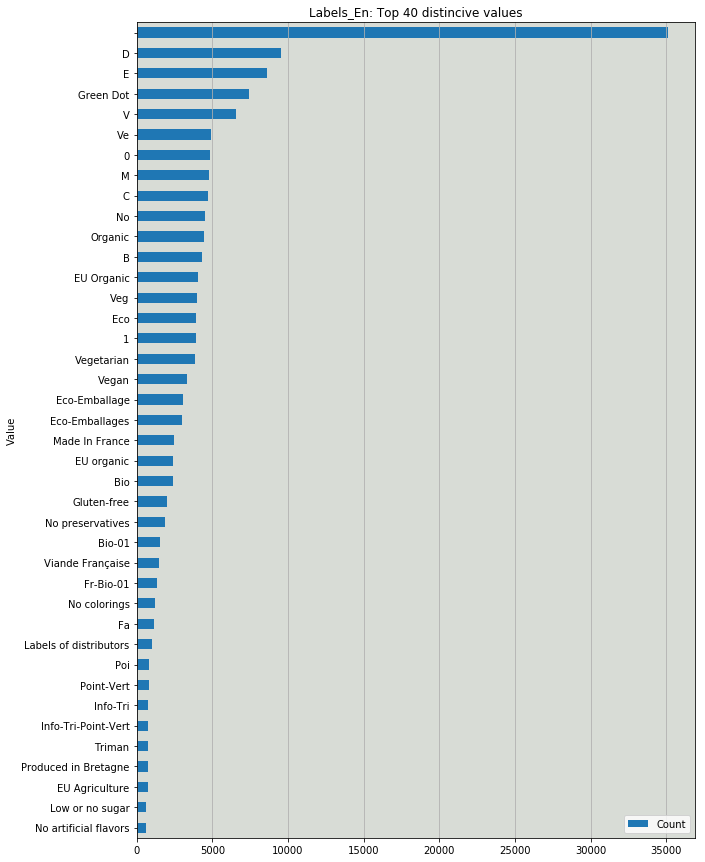

In [32]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'labels_en')

### Store labels tags

In [33]:
# Unitize store labels
with open('./data/cleanse/stores_lookup.json', 'r') as json_data:
    stores_lookup = cleanse.to_lookup(json.load(json_data))
food_facts_pd.stores = food_facts_pd.stores.fillna("").apply(lambda x: ",".join([stores_lookup[z] for z in x.split(',')]))

In [34]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'stores')

error: unbalanced parenthesis at position 2

### Food category tags

In [ ]:
if PLOT:
    _,_ = visualize.plot_occurences_of_distinct_values(food_facts_pd, 'categories_en')

## Carbon footprint dataset

Because the food facts database lacks carbon footprint specifications, we got random samples of products from Eaternity database. The goal afterward is to match Food Facts Database and Carbon Footprint database. First, let's take a look at the Carbon Footprint database.

### Loading the data

In [ ]:
# Import data
carbon_footprint_csv_file = "./data/carbon_footprint.csv"

carbon_footprint_pd = pd.read_csv(carbon_footprint_csv_file,
                            delimiter=",")

In [ ]:
carbon_footprint_pd

In [ ]:
print('We have {0} ecological features for {1} products.'\
      .format(carbon_footprint_pd.shape[1], 
              carbon_footprint_pd.shape[0]))

In [ ]:
carbon_footprint_pd.describe()

In [ ]:
carbon_footprint_pd

In [ ]:
carbon_footprint_pd.shape

We are interested in the carbon footprint of each product. Because our sample is small (around 700 products) and doesn't really match with the Food Facts Database, we will take care of the categories. Thus, we will extract the categories from [Codecheck website](https://www.codecheck.info/) (Webscraper).

In [ ]:
ax = carbon_footprint_pd['CO2-Value [gram CO2/serving]'].hist(bins=50)
ax.set_xlabel('Carbon footprint')
ax.set_ylabel('Occurencies')
ax.set_title('Distribution of the carbon ')

## Concat price info

In [35]:
prices = pd.read_csv("./web_crawler/data/prices_carbon.csv", dtype={'code':object})

In [36]:
prices_reduced = prices[['product_name', 'price_per_100g', 'store_currency']]

In [ ]:
# food_facts_pd.code = pd.to_numeric(food_facts_pd.code, errors='coerce').fillna(0).clip_upper(sys.maxsize).astype('int')
# prices_reduced.code = prices_reduced.code.clip_upper(sys.maxsize).astype('int')

Actually we should here merge on the open food facts code, because it is guaranteed to be unique. However, it cannot be written to a text file, because pandas internally transforms it to an int, thereby removing preceding zeros, which we haven't found a workaround for yet.

Also, it is consistent in the way that we query the prices by the product name, so we would obtain the same price for products of the same name.

In [37]:
food_facts_pd = pd.merge(food_facts_pd, prices_reduced, on='product_name', how='left')

In [38]:
print("Product prices successfully merged: {}".format(food_facts_pd.price_per_100g.count()))

Product prices successfully merged: 135


## Remove negative entries

In [39]:
numeric_columns = food_facts_pd.select_dtypes(include=['int16', 'int32', 'int64', 'float16', 'float32', 'float64']).columns

food_facts_pd[numeric_columns] = food_facts_pd[numeric_columns].where(food_facts_pd[numeric_columns] >= 0, np.NaN)

# Write clean data frame to CSV file

In [40]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd

    products.to_pickle("./web_crawler/products_pd.pickle")

Note : country names harmonised are available in ./data/food_facts_pd_countries_names.csv (note the additional code to go back to a list of strings). 

In [41]:
# Apply country name filter

countries_names= pd.read_csv("./data/food_facts_pd_countries_names.csv")
countries_names.origins_cleaned = \
                        countries_names.origins_cleaned.apply(lambda l: cleanse.read(l))

countries_names.manufacturing_place_cleaned = \
                        countries_names.manufacturing_place_cleaned.apply(lambda l: cleanse.read(l))

countries_names.purchase_places_cleaned = \
                        countries_names.purchase_places_cleaned.apply(lambda l: cleanse.read(l))

food_facts_pd = food_facts_pd.drop(['origins', 'manufacturing_places', 'countries_en',\
                                   'origins_tags', 'manufacturing_places_tags','purchase_places'], \
                                    axis=1)

food_facts_pd['origins_cleaned'] = countries_names.origins_cleaned
food_facts_pd['manufacturing_place_cleaned'] = countries_names.manufacturing_place_cleaned
food_facts_pd['purchase_places_cleaned'] = countries_names.purchase_places_cleaned

In [42]:
food_facts_pd = food_facts_pd.drop(['origins', 'manufacturing_places', 'countries_en',\
                   'origins_tags', 'manufacturing_places_tags','purchase_places'], axis=1)
food_facts_pd

KeyError: "labels ['origins' 'manufacturing_places' 'countries_en' 'origins_tags'\n 'manufacturing_places_tags' 'purchase_places'] not contained in axis"

In [43]:
# Write to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep=',', encoding='utf-8')

In [44]:
food_facts_pd

,code,created_t,created_datetime,product_name,quantity,packaging,brands,categories_en,labels_en,stores,...,main_category,energy_100g,carbon-footprint_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,origins_cleaned,manufacturing_place_cleaned,purchase_places_cleaned,price_per_100g,store_currency
0,0000000394710,1484497370,2017-01-15T16:22:50Z,Danoises à la cannelle roulées,1.150 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",,Costco,...,sugary-snacks,1520,,,,[Unknown],[France],[France],NaN,NaN
1,0000001071894,1409411252,2014-08-30T15:07:32Z,Flute,,"Paper,plastic film",Waitrose,"Plant-based foods and beverages,Plant-based fo...",,Waitrose,...,plant-based-foods-and-beverages,,,,,[France],[France],[France],NaN,NaN
2,0000001938067,1484501528,2017-01-15T17:32:08Z,Chaussons tressés aux pommes,1.200 kg,Frais,Kirkland Signature,"Sugary snacks,Biscuits and cakes,Pastries",,Costco,...,sugary-snacks,1090,,9,9,[Canada],[Unknown],[Canada],NaN,NaN
3,0000004302544,1488464896,2017-03-02T14:28:16Z,Pain Burger Artisan,1.008 kg / 12 pain,"Frais,plastique",Kirkland Signature,Boulange,,Costco,...,boulange,1160,,1,1,[France],[United Kingdom],[United Kingdom],NaN,NaN
4,0000007020254,1420150193,2015-01-01T22:09:53Z,Root Beer,33 cl e,"Canette,Métal",A&W,"Beverages,Carbonated drinks,Sodas,Sugared beve...","Kosher,Contient-Des-Ogm",,...,beverages,215,,18,3,[Canada],[Unknown],[Canada],NaN,NaN
5,0000007730009,1462806432,2016-05-09T15:07:12Z,Biscuits sablés fourrage au cacao,1 kg,"Carton,boîte",St Michel,"Sugary snacks,Biscuits and cakes,Biscuits,Sablés",Green Dot,,...,sugary-snacks,,,,,[Canada],[Canada],[Canada],NaN,NaN
6,0000008237798,1491943307,2017-04-11T20:41:47Z,Quiche Lorraine,1 400 kg,Frai,Kirkland Signature,"Meals,Pizzas pies and quiches,Quiches,Quiches ...",,Costco,...,meals,478,,2,2,[Unknown],[United States],"[France, United States]",NaN,NaN
7,0000008240095,1484342673,2017-01-13T21:24:33Z,Pâté au poulet,1250 kg,Frais,Kirkland Signature,"Meats,Poultries,Chickens,Cooked chicken",,Costco,...,meats,751,,,,[Unknown],[France],[France],NaN,NaN
8,0000010090206,1370977431,2013-06-11T19:03:51Z,Thé de Noël aromatisé orange-cannelle,75 g,aluminium,Alice Délice,"Plant-based foods and beverages,Beverages,Plan...",,Alice Délice,...,beverages,,,,,[Canada],[Canada],[Canada],NaN,NaN
9,0000012345878,1461364956,2016-04-22T22:42:36Z,เล็บมือนาง (ตีนไก่ ),500 g,plastic,Thai import,Chicken-feet,Incorrect data on label,,...,chicken-feet,,,,,[Canada],[Unknown],[Canada],NaN,NaN


# Write clean data frame to CSV file

In [45]:
# Generate a dataframe that extracts all information required by the web crawler
if 1==0: # skip cell
    products = food_facts_pd[['code', 'product_name', 'stores', 'carbon-footprint_100g', 'nutrition-score-fr_100g']]
    products = products[products['carbon-footprint_100g']!=""]

    products.to_pickle("./web_crawler/data/products_pd.pickle")

In [46]:
# Write to CSV file
clean_data_file_name = "./data/openfoodfacts_clean.csv"
food_facts_pd.to_csv(clean_data_file_name, sep=',', encoding='utf-8')